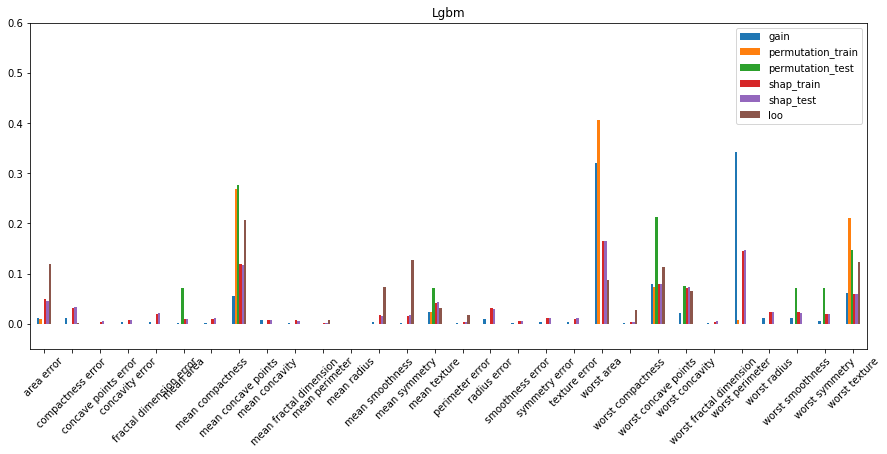

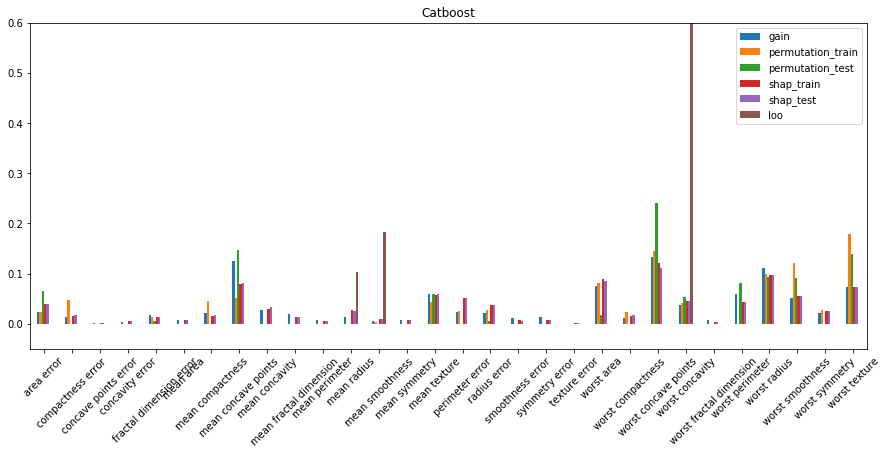

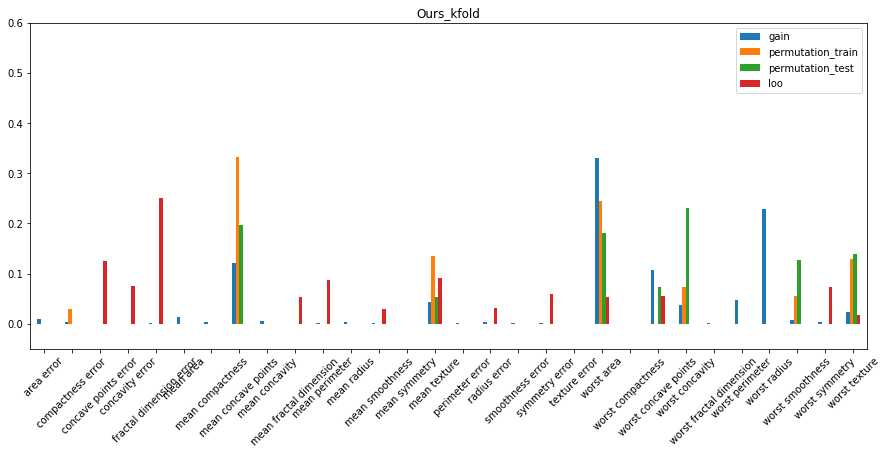

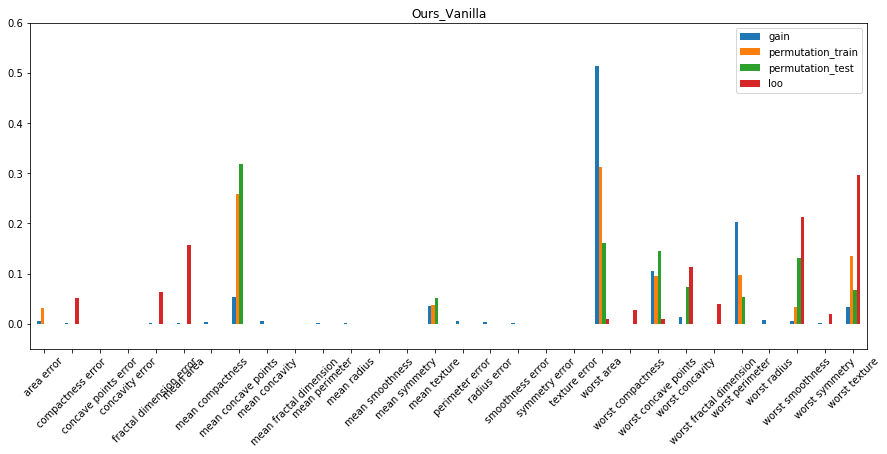

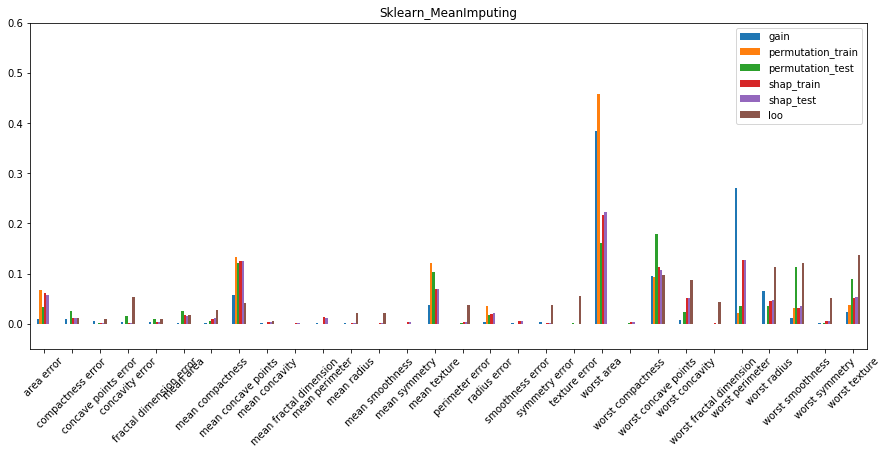

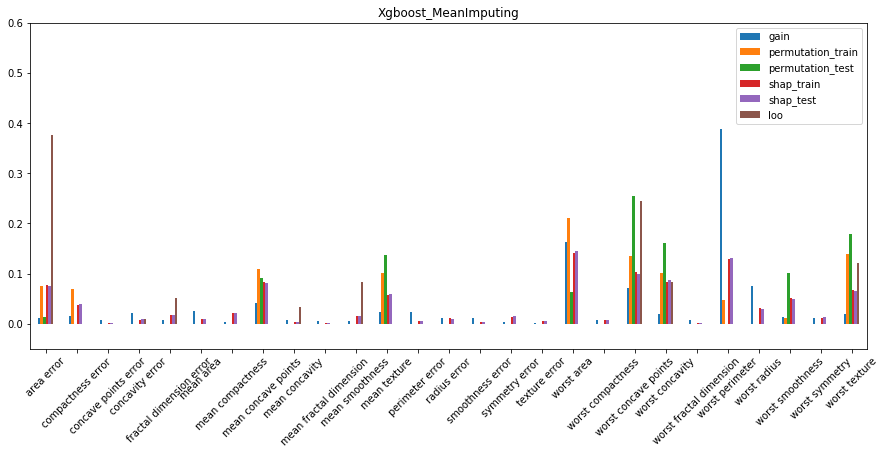

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from ast import literal_eval
from pathlib import Path


def normalize_series(s):
    if s.sum() != 0:
        s = s.apply(lambda x: max(x,0))
        return s / s.sum()
    return s

def get_regular_paths(one_hot):
    paths = {'Lgbm': "lgbm/lgbm_vanilla.csv",
             'Catboost': "catboost/catboost_vanilla.csv",
             "Ours_kfold": "ours_Kfold/ours_kfold__.csv",
             "Ours_Vanilla": "ours_vanilla/ours_vanilla__.csv",
             "Sklearn_MeanImputing": "sklearn/sklearn_mean_imputing.csv",
             'Xgboost_MeanImputing': "xgboost/xgboost_mean_imputing.csv", }
    if one_hot:
        paths.update({
            "Slearn_OneHot": "sklearn/sklearn_one_hot.csv",
            'Xgboost_OneHot': "xgboost/xgboost_one_hot.csv"})
    return paths


def get_loo_fi(path, features):
    fi = []
    all_features__metric = pd.read_csv(path)['logloss'][0]
    start_string, end_string = path.split('.')
    for feature in features:
        temp_path = F"{start_string}_{feature}.{end_string}"
        sub_group_metric = pd.read_csv(temp_path)['logloss'][0]
        fi.append(sub_group_metric - all_features__metric)
    return fi


def get_feature_importance(exp, path, loo):
    all_cols = ['gain', 'permutation_train', 'permutation_test', 'shap_train', 'shap_test']
    our_cols = ['gain', 'permutation_train', 'permutation_test']
    cols = our_cols if exp.startswith('Ours') else all_cols
    df = pd.read_csv(path, converters={col: literal_eval for col in cols})
    results = pd.DataFrame()
    for col in cols:
        results[col] = pd.Series(df.loc[0, col])
    results = results.sort_index()
    if loo:
        results['loo'] = get_loo_fi(path, results.index.tolist())
        results['loo'] = normalize_series(results['loo'])
    return results


if __name__ == '__main__':
    ONE_HOT = False
    LOO = True
    paths = get_regular_paths(ONE_HOT)
    for k, v in paths.items():
        # results = get_feature_importance(k, v, LOO)
        plot = get_feature_importance(k, v, LOO).plot(kind='bar', figsize=(15, 6), title=k, ylim=(-0.05, 0.6), rot=45)
        plot.figure.savefig(F"{k}_feature_importance.png")


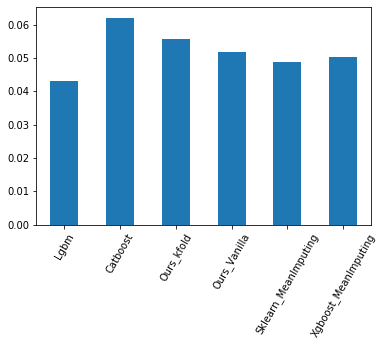

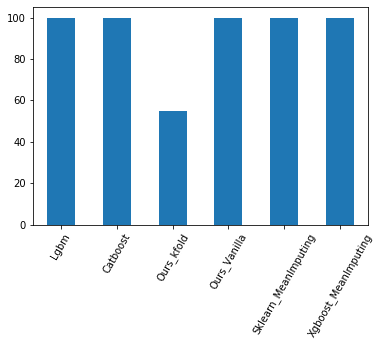

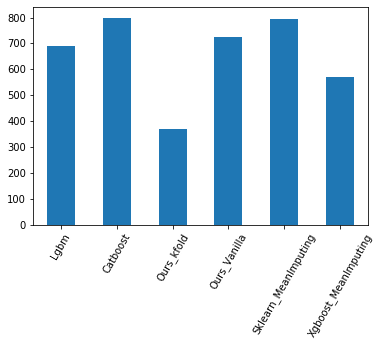

In [3]:
for metric in ['logloss', 'ntrees', 'nleaves']: 
    results = {}
    for model, path in paths.items():
        results[model] = pd.read_csv(paths[model])[metric][0]
    plot = pd.Series(results).plot(kind='bar', rot = 60)
    plt.show()